In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

# Get a handle to the workspace. You can find the info on the workspace tab on ml.azure.com
ml_client = MLClient(
    credential=credential,
    subscription_id="<SUBSCRIPTION_ID>",  # this will look like xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx
    resource_group_name="<RESOURCE_GROUP>",
    workspace_name="<AML_WORKSPACE_NAME>",
)

ModuleNotFoundError: No module named 'azure.ai'

In [2]:
from azureml.core import Workspace, Dataset, Experiment

ws = Workspace.from_config()
experiment = Experiment(workspace=ws, name='sdg-bert-training')

In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv("final_training_set.csv", engine="python")

In [4]:
import os
from azureml.core import Run

run = Run.get_context()

In [5]:
#%pip install sklearn

In [6]:

from sklearn.model_selection import train_test_split

# Split into train (80%), temp (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train["text"], train["sdg"],
    test_size=0.2,
    stratify=train["sdg"],  # Preserve class balance
    random_state=139390
)

# Split temp into val (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [30]:
#%pip install transformers

In [7]:
# Using the same tokenizer as the model

from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sadickam/sdgBERT")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
#%pip install torch

In [8]:
import torch
# Tokenize a batch of texts
def tokenize(batch_texts):
    return tokenizer(
        batch_texts,
        padding="max_length",    # Pad to max_length
        truncation=True,         # Truncate to max_length
        max_length=512,          # Match the original model's max length
        return_tensors="pt",     # Return PyTorch tensors
    )

# Example tokenization for training texts
tokenized_train = tokenize(train_texts.tolist())

In [9]:
from torch.utils.data import Dataset, DataLoader
class SDGDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenize(texts.tolist())  # Tokenize all texts upfront

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Create datasets
train_dataset = SDGDataset(train_texts, train_labels)
val_dataset = SDGDataset(val_texts, val_labels)
test_dataset = SDGDataset(test_texts, test_labels)

In [10]:
batch_size = 16  # Adjust based on GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,    # Shuffle for training
    num_workers=4    # Parallelize data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,   # No need to shuffle validation
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "sadickam/sdgBERT",
    num_labels=17,  # 16 SDGs + residual
    ignore_mismatched_sizes=True  # Required to resize the classifier layer
)

# Verify model architecture
print(model.classifier)  # Should show `out_features=17`

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Linear(in_features=768, out_features=17, bias=True)


In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)
model = model.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [13]:
#%pip install tf-keras
#%pip install 'accelerate>=0.26.0'
#%pip install transformers[torch]

In [14]:
output_dir = os.path.join('./outputs', 'sdgBERT_with_residual_final')
os.makedirs(output_dir, exist_ok=True)

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_dir,  # Azure ML automatically uploads './outputs'
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="azure_ml"  # For Azure ML integration
)

2025-02-08 13:51:12.226963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 13:51:13.711490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 13:51:14.135663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 13:51:17.514887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 13:51:24.499357: W tensorflow/comp

In [16]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, 17), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


# Initialize Trainer with fixed compute_loss
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [17]:
# Train and save
trainer.train()
trainer.save_model(output_dir)

Epoch,Training Loss,Validation Loss
1,41818372702.208000,28854620160.000000
2,19644870033.408001,33404884992.000000
3,12137329065.983999,21628852224.000000
4,9093381095.424000,24650346496.000000


Attempted to log scalar metric loss:
87958656909.312
Attempted to log scalar metric learning_rate:
1.8449131513647644e-05
Attempted to log scalar metric epoch:
0.31
Attempted to log scalar metric loss:
40291985784.832
Attempted to log scalar metric learning_rate:
1.6898263027295287e-05
Attempted to log scalar metric epoch:
0.62
Attempted to log scalar metric loss:
41818372702.208
Attempted to log scalar metric learning_rate:
1.534739454094293e-05
Attempted to log scalar metric epoch:
0.93
Attempted to log scalar metric eval_loss:
28854620160.0
Attempted to log scalar metric eval_runtime:
377.6708
Attempted to log scalar metric eval_samples_per_second:
8.531
Attempted to log scalar metric eval_steps_per_second:
0.535
Attempted to log scalar metric epoch:
1.0
Attempted to log scalar metric loss:
25038543650.816
Attempted to log scalar metric learning_rate:
1.379652605459057e-05
Attempted to log scalar metric epoch:
1.24
Attempted to log scalar metric loss:
21799010041.856
Attempted to lo

In [18]:
run.upload_folder('outputs', output_dir)

Attempted to track folder outputs at ./outputs/sdgBERT_with_residual_final


In [19]:
# Generate predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       0.89      0.84      0.86       161
           2       0.76      0.84      0.80       124
           3       0.92      0.95      0.94       208
           4       0.96      0.92      0.94       286
           5       0.85      0.87      0.86       327
           6       0.91      0.82      0.87       165
           7       0.95      0.88      0.91       231
           8       0.65      0.66      0.65       100
           9       0.85      0.91      0.88       192
          10       0.80      0.77      0.78       129
          11       0.89      0.90      0.89       149
          12       0.89      0.81      0.85        70
          13       0.82      0.94      0.87       146
          14       0.92      0.94      0.93        89
          15       0.90      0.90      0.90       166
          16       0.99      0.98      0.99       330

    accuracy              

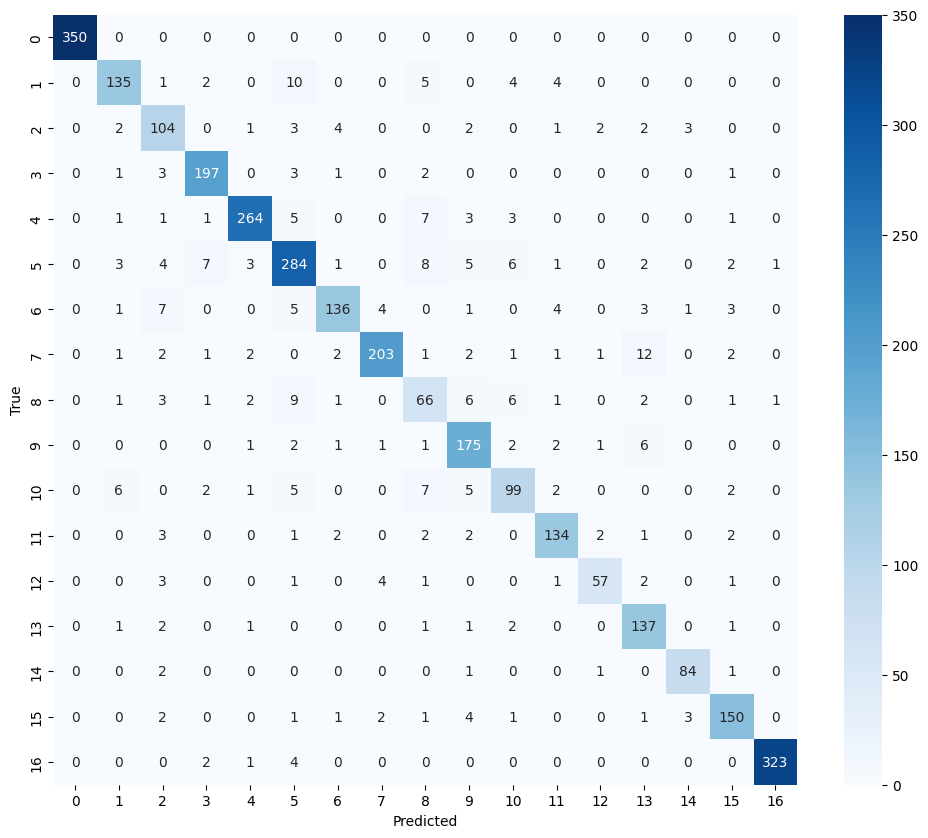

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
from azureml.core.model import Model

# Register model
model = Model.register(
    workspace=ws,
    model_path=output_dir,
    model_name="sdgBERT_residual",
    tags={'framework': 'PyTorch', 'task': 'text-classification'},
    description="SDG classification model with residual category"
)


Registering model sdgBERT_residual


In [22]:
from azureml.core.model import Model

model = Model(ws, 'sdgBERT_residual')
model.download(target_dir='Users/moises.silvaservin/', exist_ok=True)

'Users/moises.silvaservin/sdgBERT_with_residual_final'

In [25]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
model = ml_client.models.get(name="sdgBERT_residual")
model.download(download_path="'Users/moises.silvaservin/'")


ModuleNotFoundError: No module named 'azure.ai'

In [26]:
!pip install azure-ai-ml azure-identity

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.4/286.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: opentelemetry-api
    Found existing installation: opentelemetry-api 1.26.0
 